In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# ensuring gpu is connected
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
!pip install pytorch-transformers
!pip install matplotlib==3.1.0

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from pytorch_transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [0]:
# read data
X_train = pd.read_pickle('/content/drive/My Drive/train_test_v2/X_train.pkl')
X_test = pd.read_pickle('/content/drive/My Drive/train_test_v2/X_test.pkl')
y_train = pd.read_pickle('/content/drive/My Drive/train_test_v1/y_train.pkl')
y_test = pd.read_pickle('/content/drive/My Drive/train_test_v1/y_test.pkl')

# remove problematic points
X_train = X_train.drop([5983])
y_train = y_train.drop([5983])

X_test = X_test.drop([2878, 3113, 3350, 3395, 3476, 3494])
y_test = y_test.drop([2878, 3113, 3350, 3395, 3476, 3494])

# convert into tabspaced tsvs
train_df = pd.DataFrame({
    'id':X_train.index,
    'label':y_train['label'].values,
    'alpha':['a']*X_train.shape[0],
    'text':X_train['article_text']
})
train_df['text'] = train_df['text'].apply(lambda x: ' '.join(x.split()))
# train_df.head()

test_df=pd.DataFrame({
    'id':X_test.index,
    'label':y_test['label'].values,
    'alpha':['a']*X_test.shape[0],
    'text':X_test['article_text']
})
test_df['text'] = test_df['text'].apply(lambda x: ' '.join(x.split()))
# test_df.head()

train_df.to_csv('./train.tsv', sep='\t', index=False, header=False)
test_df.to_csv('./dev.tsv', sep='\t', index=False, header=False)

In [0]:
train_df = pd.read_csv("./train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
test_df = pd.read_csv("./dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [0]:
train_sentences = train_df.sentence.values
train_sentences = np.array([y.replace('.', '.[SEP]') + '[CLS]' for y in train_sentences])
train_labels = train_df.label.values

# for test
test_sentences = test_df.sentence.values
test_sentences = np.array([y.replace('.', '.[SEP]') + '[CLS]' for y in test_sentences])
test_labels = test_df.label.values

In [0]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased', do_lower_case=False)

tokenized_train_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
tokenized_test_texts = [tokenizer.tokenize(sent) for sent in test_sentences]

print ("Tokenize the first sentence:")
print (tokenized_train_texts[0])

100%|██████████| 798011/798011 [00:00<00:00, 1950661.31B/s]


Tokenize the first sentence:
['▁News', '▁flash', ':', '▁There', "'", 's', '▁a', '▁crisis', '▁at', '▁the', '▁border', '.', '[', 'S', 'EP', ']', '▁This', '▁was', '▁discovered', '▁again', '▁over', '▁the', '▁past', '▁few', '▁days', '▁when', '▁immigration', '▁attorneys', '▁talked', '▁to', '▁reporters', '▁about', '▁appalling', '▁conditions', '▁at', '▁a', '▁Border', '▁Patrol', '▁facility', '▁detain', 'ing', '▁migrant', '▁minor', 's', '▁in', '▁Clint', ',', '▁Texas', '.', '[', 'S', 'EP', ']', '▁According', '▁to', '▁the', '▁lawyers', ',', '▁many', '▁of', '▁the', '▁kids', '▁had', '▁to', '▁sleep', '▁on', '▁the', '▁concrete', '▁floor', ',', '▁failed', '▁to', '▁get', '▁proper', '▁adult', '▁supervision', '▁and', '▁didn', "'", 't', '▁routinely', '▁take', '▁showers', '▁or', '▁brush', '▁their', '▁teeth', '.', '[', 'S', 'EP', ']', '▁The', '▁details', '▁were', '▁hard', '▁to', '▁read', '.', '[', 'S', 'EP', ']', '▁Assuming', '▁the', '▁account', '▁was', '▁accurate', ',', '▁one', '▁wonders', '▁how', '▁we', '▁

In [0]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
MAX_LEN = 256

In [0]:
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
train_inputs_1 = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_train_texts]
test_inputs = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_test_texts]

In [0]:
# Pad our input tokens
train_inputs_1 = pad_sequences(train_inputs_1, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
test_inputs = pad_sequences(test_inputs, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
# Create attention masks
train_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in train_inputs_1:
  seq_mask = [float(i>0) for i in seq]
  train_attention_masks.append(seq_mask)

# Create attention masks
test_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in test_inputs:
  seq_mask = [float(i>0) for i in seq]
  test_attention_masks.append(seq_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_inputs_1, train_labels, 
                                                            random_state=2018, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(train_attention_masks, train_inputs_1,
                                             random_state=2018, test_size=0.2)

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 8

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [0]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

model = XLNetForSequenceClassification.from_pretrained("xlnet-large-cased", num_labels=2)
model.cuda()

100%|██████████| 1441285815/1441285815 [00:47<00:00, 30084264.63B/s]


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 1024)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=1024, out_features=4096, bias=True)
          (layer_2): Linear(in_features=4096, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((1024,),

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [0]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.3999779659362746


Epoch:  25%|██▌       | 1/4 [14:21<43:04, 861.65s/it]

Validation Accuracy: 0.9096875000000001
Train loss: 0.233403521885801


Epoch:  50%|█████     | 2/4 [28:42<28:42, 861.39s/it]

Validation Accuracy: 0.81953125
Train loss: 0.17159968688617663


Epoch:  75%|███████▌  | 3/4 [43:03<14:21, 861.27s/it]

Validation Accuracy: 0.90890625
Train loss: 0.11805544861815345


Epoch: 100%|██████████| 4/4 [57:22<00:00, 860.63s/it]

Validation Accuracy: 0.9307812500000001


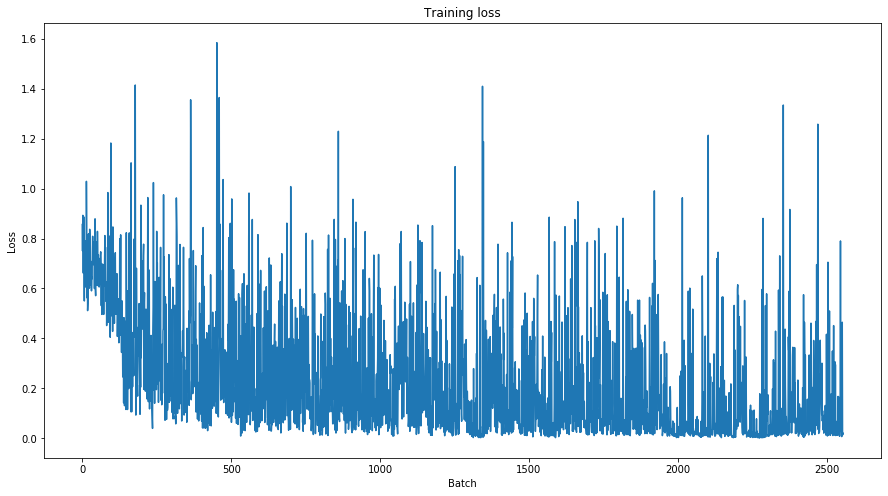

In [0]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [0]:
prediction_inputs = torch.tensor(test_inputs)
prediction_masks = torch.tensor(test_attention_masks)
prediction_labels = torch.tensor(test_labels)
  
batch_size = 8  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels, probabilities = [], [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  probabilities.append(np.divide(np.exp(logits), np.sum(np.exp(logits), axis=1)[:, None]))
  true_labels.append(label_ids)

In [0]:
# model testing
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix 
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, brier_score_loss, recall_score, precision_score
# from sklearn.utils.fixes import signature
from inspect import signature
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [0]:
def find_cutoff(ground_truth, predictions, metric):
    best_score = 0
    best_cutoff = 0
    for i in np.linspace(0, 1, 101):
        y_pred = (predictions>=i).astype(int)
        score = metric(y_true = ground_truth, y_pred = y_pred)
        if score >= best_score:
            best_cutoff = i
            best_score = score
    return best_cutoff

In [0]:
preds = np.concatenate([i[:,1] for i in probabilities]).ravel()
y_true = np.concatenate([i.flatten() for i in true_labels]).ravel()

best_cutoff = find_cutoff(ground_truth=y_true, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)

In [0]:
def ml_report(model, y_true, predictions, cutoff = 0.5, top_feats = 10):
    y_pred = (preds>=cutoff).astype(int)
    print("Classification report:\n%s\n"
          % classification_report(y_true, y_pred, digits = 3))
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 4))
    
    # print model performance
    print("F1 Score: %.3f" %f1_score(y_true, y_pred))
    print("Recall: %.3f" %recall_score(y_true, y_pred))
    print("Precision: %.3f" %precision_score(y_true, y_pred))
    print("Accuracy: %.3f" %accuracy_score(y_true, y_pred))
    print("Brier Score: %.4f" %brier_score_loss(y_true, y_pred))
    
    # confusion matrix
    plt.subplot(1, 4, 1)
    df_cm = pd.DataFrame(
        confusion_matrix(y_test, y_pred), 
        index=[0, 1], 
        columns=[0, 1], 
    )
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # roc curve
    plt.subplot(1, 4, 2)
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, '#e74c3c', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--', color = '#34495e')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    # p-r curve
    plt.subplot(1, 4, 3)
    average_precision = average_precision_score(y_true, preds)
    precision, recall, _ = precision_recall_curve(y_true, preds)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='#e74c3c', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='#e74c3c', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.4f}'.format(
              average_precision))
    plt.show()

Classification report:
              precision    recall  f1-score   support

           0      0.980     0.965     0.972      3077
           1      0.730     0.827     0.776       353

    accuracy                          0.951      3430
   macro avg      0.855     0.896     0.874      3430
weighted avg      0.954     0.951     0.952      3430


F1 Score: 0.776
Recall: 0.827
Precision: 0.730
Accuracy: 0.951
Brier Score: 0.0493


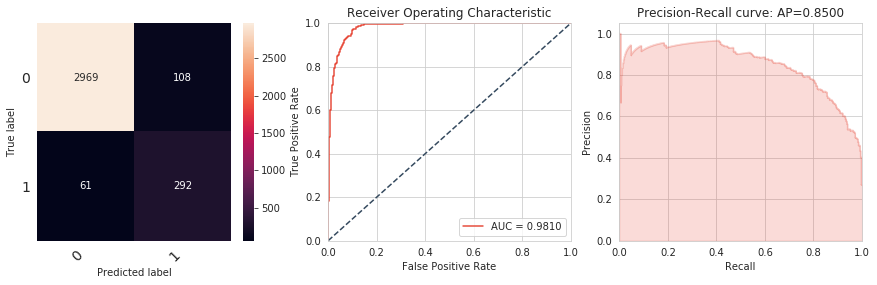

In [0]:
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)